## Alinhamento de Sequências Biologicas utilizando _Profile Hidden Markov Models_
### Projeto Final Machine Learning

Neste projeto, eu utilizei o modelo conhecido como Hidden Markov Models, mais comumente chamado de HMM, que é um modelo probabilistico aplicado na análise de alinhamento de multiplas sequências de proteínas - **multiple sequence alignment (msa)**

Neste modelo, dada multiplas sequências biológicas, cada coluna de simbolos representa um alinhamento. Cada símbolo (que irei me referir como **estado**) possui uma distribuição de frequência. Além dos simbolos, _inserções_ e _deleções_ entre simbolos, irão representar outros estados.

A transição de um estado para o outro ao londo de um caminho particular, é uma cadeia de Markov (ou seja, escolha aleatória do próximo movimento), tentando dar um _"match"_ no próximo simbolo. O próximo "matching symbol" é escolhido no estado a estado, registrando suas probabilidades (frequências) e também a probabilidade de ir para aquele estado de uma anterior (a probabilidade de transição). 

Estados e probabilidades de transição são multiplicadas para obter a probabilidade de uma dada sequência. A natureza oculta, aka "hidden", de um HMM é devido à falta de informação sobre o valor de um estado específico, que é representado por uma distribuição de probabilidade sobre todos os valores possíveis. É devida essa natureza, que o modelo se torna um modelo de aprendizagem. 

In [3]:
#Python tools for computational molecular biology
%pip install biopython
#Another Hidden Markov Model library
%pip install pomegranate
#Hidden Markov Models learn library
%pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#For better visualizations
#%pip install pygraphviz

In [5]:
# Important modules 
from __future__ import print_function, division
from future.utils import iteritems
from builtins import range, input

import argparse, sys

import matplotlib
import matplotlib as mpl
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd 
import numpy as np
import Bio
import timeit

from Bio.Seq import Seq
from Bio import SeqIO
from sklearn.utils import shuffle
from scipy.io import loadmat
from scipy.stats import norm
from pomegranate import *

from hmmlearn import hmm
from multiprocessing import Pool, TimeoutError

In [6]:
print("Biopython v" + Bio.__version__)

Biopython v1.73


#### Sobre o dataset: 

O banco de dados [Pfam](http://pfam.xfam.org/) contém uma larga coleção de famílias de proteinas, cada uma representando por multiplos alinhamentos de sequências e HMMs. 

[Pfam References](http://pfam.xfam.org/help?tab=helpReferencesBlock):
[The Pfam protein families database in 2019](https://academic.oup.com/nar/article/47/D1/D427/5144153): S. El-Gebali, J. Mistry, A. Bateman, S.R. Eddy, A. Luciani, S.C. Potter, M. Qureshi, L.J. Richardson, G.A. Salazar, A. Smart, E.L.L. Sonnhammer, L. Hirsh, L. Paladin, D. Piovesan, S.C.E. Tosatto, R.D. Finn
Nucleic Acids Research (2019)  doi: 10.1093/nar/gky995


__Dataset used: [Family: Miga (PF10265)](http://pfam.xfam.org/family/PF10265#alignBlock)__
Mitoguardin (Miga) foi identificado pela primeira vez em moscas como uma proteína da membrana externa mitocondrial que promove a fusão mitocondrial. 

#### Sobre o formato do dataset: 
Em bioinformática e bioquímica, o formato FASTA é um formato baseado em texto para representar sequências nucleotídicas ou sequências de aminoácidos (proteínas), nas quais nucleótidos ou aminoácidos são representados usando códigos de letra única. O formato também permite que nomes de sequência e comentários precedam as sequências.

In [7]:
input_file = "PF10265_seed.fasta"
input_file_high_lenght = "miga.fasta"
input_file_small_lenght = "zincFinger.fasta"

#### Parsing sequence: 

In [16]:
def fasta_reader(input_file):
    from Bio.SeqIO.FastaIO import FastaIterator
    with open(input_file) as handle:
        for record in FastaIterator(handle):
            yield record

msa = []
for entry in fasta_reader(input_file):
    msa.append(entry.seq)
    #msa_train.append(entry.seq)
    print ("ID:", str(entry.id), "\t Lenght:", str("{:,d}".format(len(entry))) ) #This is header of fasta entry
    print (repr(entry.seq), "\n") #This is sequence of specific fasta entry
    #print (str(entry.seq), "\n") #This is sequence of specific fasta entry
    
#print(msa)

ID: MIGA1_HUMAN/59-603 	 Lenght: 629
Seq('WYYSLSQIKFSP-VAKKLFVVTAVSA---ISVIFLAHHFKRKRGKKKG---KIL...AYL', SingleLetterAlphabet()) 

ID: MIGA2_DANRE/31-565 	 Lenght: 629
Seq('GQSIFSQLKLSP-SLKKVLFATALGS---VALALTAHQLKRRGRKRKQ-TLGKE...GYL', SingleLetterAlphabet()) 

ID: MIGA2_MOUSE/31-568 	 Lenght: 629
Seq('GQSAFSQLRLTP-GLRKVLFATALGT---VALALAAHQLKRRRRKKKQVGPEMG...GYL', SingleLetterAlphabet()) 

ID: Q7PZ24_ANOGA/2-507 	 Lenght: 629
Seq('SVSKYLPIHVST-SQKIIILSVSAGV---ALLGALAAYLGRRRTPLPQ------...VKF', SingleLetterAlphabet()) 

ID: R0LVY4_ANAPL/31-569 	 Lenght: 629
Seq('GQSVFSQLRLSP-GLRKVLFATALGT---VALALAAHQLKRRRRRKKQIAPDKC...GYL', SingleLetterAlphabet()) 



#### Teste exato realizado com o algoritmo de Viterbi, e dados inseridos manualmente de uma sequência de ACTG. 

In [18]:
import warnings
warnings.filterwarnings('ignore')

hmm = HiddenMarkovModel()
model = HiddenMarkovModel( "Global Alignment")

# Distribution for insertions
insertions_distributions = DiscreteDistribution( { 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 } )

# Create the insert states
i0 = State( insertions_distributions, name="I0" )
i1 = State( insertions_distributions, name="I1" )
i2 = State( insertions_distributions, name="I2" )
i3 = State( insertions_distributions, name="I3" )

# Create the match states
m1 = State( DiscreteDistribution({ "A": 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02 }) , name="M1" )
m2 = State( DiscreteDistribution({ "A": 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004 }) , name="M2" )
m3 = State( DiscreteDistribution({ "A": 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97 }) , name="M3" )

# Create the delete states
d1 = State( None, name="D1" )
d2 = State( None, name="D2" )
d3 = State( None, name="D3" )

# Add all the states to the model
model.add_states( [i0, i1, i2, i3, m1, m2, m3, d1, d2, d3 ] )

# Create transitions from match states
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )
model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )
model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )

# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

Sequence: 'ACT'  -- Log Probability: -0.5132449003570658 -- Path: M1 M2 M3
Sequence: 'GGC'  -- Log Probability: -11.048101241343396 -- Path: I0 I0 D1 M2 D3
Sequence: 'GAT'  -- Log Probability: -9.125519674022627 -- Path: I0 M1 D2 M3
Sequence: 'ACC'  -- Log Probability: -5.0879558788604475 -- Path: M1 M2 M3


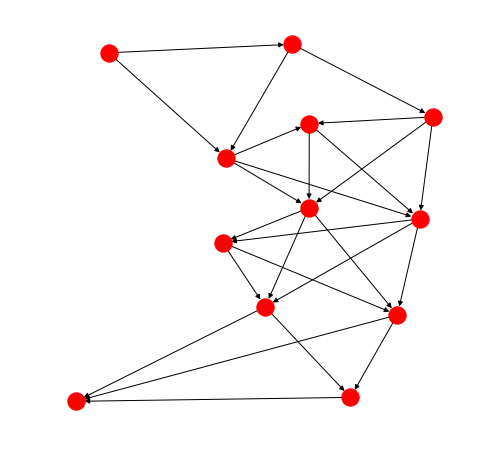

In [19]:
# Call bake to finalize the structure of the model.
model.bake()

plt.figure(figsize=(6,6))
model.plot()

for sequence in map( list, ('ACT', 'GGC', 'GAT', 'ACC') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

In [20]:
for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


In [25]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1 D2 D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0 M1 D2 D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1 M2 D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1 D2 M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1 D2 M3 I3 I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1 M2 I2 I2 I2 D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1 I1 I1 D2 M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


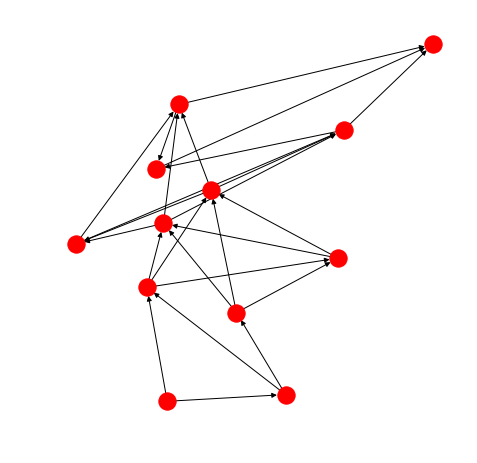

In [24]:
# Call bake to finalize the structure of the model.
model.bake()

plt.figure(figsize=(6,6))
model.plot()

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print ("Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) ))